# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [176]:
# auxilary imports
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F  # noqa

First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [177]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /mnt/d/Studies/CBS - Electives/AI and ML/ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [178]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [179]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = get_device()

Running pytorch version (2.5.1) with backend = cpu


In [180]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

No GPU available. Training will run on CPU.


In [181]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 2. Load data

In [182]:
# load the training/validation data
train_val = load_torch_data(
    dataset="MNIST",
    root = 'data',                     # The root directory where the dataset will be stored
    download = True,                   # If the dataset is not found at root, it will be downloaded
    train = True,                      # The train dataset (as opposed to the test dataset)
    transform = transforms.ToTensor()  # transformations to be applied to the dataset (only cast to tensor)
)

# load the testing data
test = load_torch_data(
    dataset = "MNIST",
    root = 'data',
    download = True,
    train = False,
    transform = transforms.ToTensor()
)

f"{len(train_val)=}, {len(test)=}"

'len(train_val)=60000, len(test)=10000'

In [183]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [184]:
# create dataloders for easy batch loading during training
train_loader = to_dataloader(train, batch_size = 64, shuffle = True)
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 5


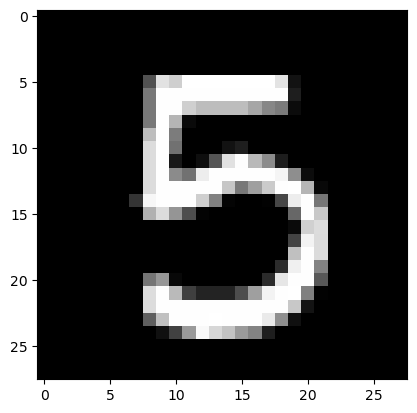

In [185]:
# Pick a random example from the training set
selection = random.randrange(len(train)-1)
image, label = train[selection]

# Plot the image
print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

# Print the label
print(f"The label for this image: {label}")


***

### 4. Artificial neural network

In [204]:
import math

# Works with SGD optimizer, 0.05 step

class MLP(nn.Module):

  def __init__(self):
    super().__init__()
    # TODO: define layers
    # Initial input = 28x28 pixels big ~ 784
    # Last output = 10, we try to recognize 10 different digits
    self.fc1 = nn.Linear(784, math.ceil(784/2))
    self.fc2 = nn.Linear(math.ceil(784/2), math.ceil(784/4))
    self.fc3 = nn.Linear(math.ceil(784/4),math.ceil(784/8)) 
    self.fc4 = nn.Linear(math.ceil(784/8),math.ceil(784/16)) 
    self.fc5 = nn.Linear(math.ceil(784/16),math.ceil(784/32)) 
    self.fc6 = nn.Linear(math.ceil(784/32),10) 
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor):
    # TODO: define forward pass
    x = self.fc1(x) # first pass where we convert our input into the first hidden layer
    x = self.relu(x)  # ReLU
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    x = self.relu(x)
    x = self.fc6(x)
    
    return x

In [ ]:
import math

# works with Adam optimizer, 0.001 step

class MLP(nn.Module):

  def __init__(self):
    super().__init__()
    # TODO: define layers
    # Initial input = 28x28 pixels big ~ 784
    # Last output = 10, we try to recognize 10 different digits
    self.fc1 = nn.Linear(784, math.ceil(784/4))
    self.fc2 = nn.Linear(math.ceil(784/4), math.ceil(784/16))
    self.fc3 = nn.Linear(math.ceil(784/16),10) 
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor):
    # TODO: define forward pass
    x = self.fc1(x) # first pass where we convert our input into the first hidden layer
    x = self.relu(x)  # ReLU
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    
    return x

### 5. Training hyperparameters

In [205]:
LR = 0.001  # TODO: define the learning rate
NUM_EPOCHS = 20 # TODO: define the number of epochs (i.e. passes over the dataset)
criterion = nn.CrossEntropyLoss()  # The loss function

Instantiate the model and optimizer

In [206]:
model = MLP().to(DEVICE)   # Create an instance of the MLP model and move it to device (GPU or CPU)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) # The optimizer (here, SGD - you can also try ADAM)

In [207]:
model

MLP(
  (fc1): Linear(in_features=784, out_features=392, bias=True)
  (fc2): Linear(in_features=392, out_features=196, bias=True)
  (fc3): Linear(in_features=196, out_features=98, bias=True)
  (fc4): Linear(in_features=98, out_features=49, bias=True)
  (fc5): Linear(in_features=49, out_features=25, bias=True)
  (fc6): Linear(in_features=25, out_features=10, bias=True)
  (relu): ReLU()
)

### 6. Training

In [208]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = NUM_EPOCHS
)

Epoch [1/20]: Train Loss: 0.4253 | Train Accuracy: 86.58% | Val Loss: 0.1795 | Val Accuracy: 94.58%
Epoch [2/20]: Train Loss: 0.1378 | Train Accuracy: 95.77% | Val Loss: 0.1305 | Val Accuracy: 96.26%
Epoch [3/20]: Train Loss: 0.0940 | Train Accuracy: 97.19% | Val Loss: 0.1316 | Val Accuracy: 95.99%
Epoch [4/20]: Train Loss: 0.0686 | Train Accuracy: 97.96% | Val Loss: 0.1255 | Val Accuracy: 96.54%
Epoch [5/20]: Train Loss: 0.0560 | Train Accuracy: 98.30% | Val Loss: 0.1104 | Val Accuracy: 97.06%
Epoch [6/20]: Train Loss: 0.0450 | Train Accuracy: 98.63% | Val Loss: 0.1093 | Val Accuracy: 97.04%
Epoch [7/20]: Train Loss: 0.0369 | Train Accuracy: 98.89% | Val Loss: 0.0981 | Val Accuracy: 97.13%
Epoch [8/20]: Train Loss: 0.0322 | Train Accuracy: 98.99% | Val Loss: 0.1159 | Val Accuracy: 97.21%
Epoch [9/20]: Train Loss: 0.0292 | Train Accuracy: 99.09% | Val Loss: 0.1022 | Val Accuracy: 97.47%
Epoch [10/20]: Train Loss: 0.0234 | Train Accuracy: 99.27% | Val Loss: 0.1116 | Val Accuracy: 97.24%

### 7. Plot loss and accuracy

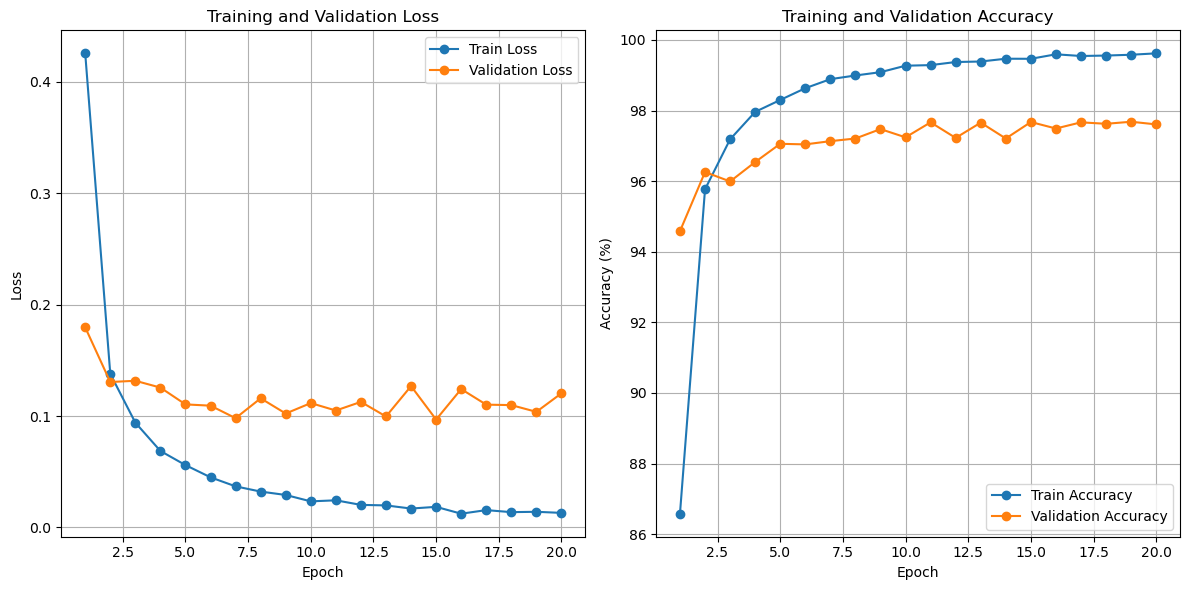

In [209]:
plot_training_history(history)

### 8. Evaluate

In [210]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.0086, Accuracy: 99.74%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4735
           1       1.00      1.00      1.00      5383
           2       1.00      1.00      1.00      4762
           3       1.00      1.00      1.00      4886
           4       1.00      1.00      1.00      4681
           5       1.00      0.99      1.00      4368
           6       0.99      1.00      1.00      4752
           7       1.00      1.00      1.00      4983
           8       1.00      1.00      1.00      4674
           9       0.99      1.00      1.00      4776

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000



In [211]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1204, Accuracy: 97.61%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1188
           1       0.99      0.99      0.99      1359
           2       0.96      0.98      0.97      1196
           3       0.98      0.97      0.98      1245
           4       0.98      0.98      0.98      1161
           5       0.99      0.96      0.97      1053
           6       0.97      0.99      0.98      1166
           7       0.99      0.98      0.98      1282
           8       0.97      0.97      0.97      1177
           9       0.96      0.97      0.96      1173

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



In [212]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1220, Accuracy: 97.77%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.96      0.97       892
           6       0.97      0.99      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

